# Определение возраста покупателей

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
print(labels.head(10))
print('#'*50)
print(labels.describe(include='all'))
print('#'*50)
print(labels.info())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39
##################################################
         file_name     real_age
count         7591  7591.000000
unique        7591          NaN
top     004800.jpg          NaN
freq             1          NaN
mean           NaN    31.201159
std            NaN    17.145060
min            NaN     1.000000
25%            NaN    20.000000
50%            NaN    29.000000
75%            NaN    41.000000
max            NaN   100.000000
##################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-nu

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)

valid_gen_flow = valid_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)

print('Размер обучающей выборки:', len(train_gen_flow.filenames))
print('Размер валидационной выборки:', len(valid_gen_flow.filenames))

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Размер обучающей выборки: 5694
Размер валидационной выборки: 1897


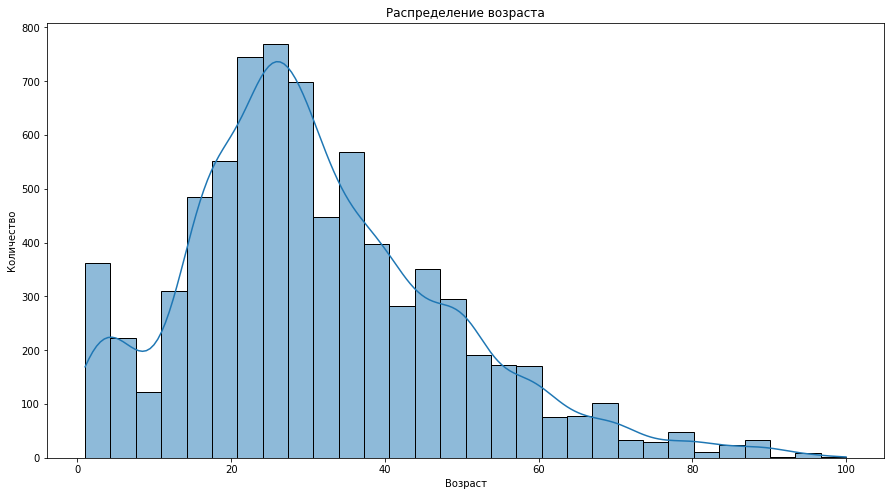

In [5]:
plt.figure(figsize=(15, 8))
sns.histplot(data=labels, x='real_age', kde=True, bins=30)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста')
plt.show()

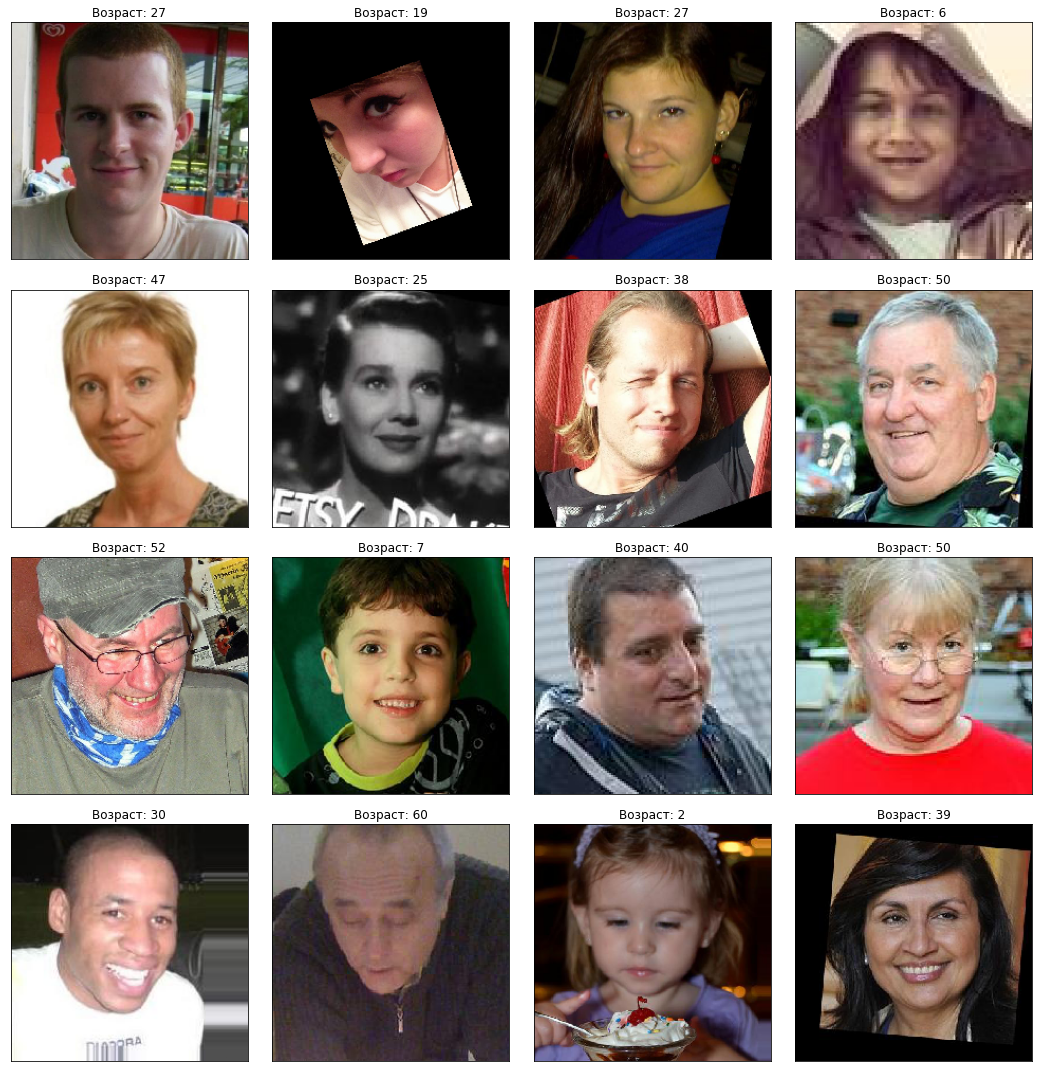

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15, 15))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(features[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Возраст: {target[i]}')
    plt.tight_layout()

Вывод:

- Данные содержат информацию о 7591 фотографии с указанием имени файла и реального возраста покупателя.
- Средний возраст людей на фото составляет 31 год, с минимальным возрастом 1 год и максимальным возрастом 100 лет.
- В выборке преобладают возрастные группы от 18 до 40 лет.
- Были показаны 16 случайных изображений с указанием возраста.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1/255. ,
                                       vertical_flip=True, 
                                       validation_split=0.25)
    
    labels = pd.read_csv(f'{path}labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(  
        dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
   
    return train_datagen_flow 


def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    labels = pd.read_csv(f'{path}labels.csv')

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)


    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #один нейрон
    model.add(Dense(1, activation='relu')) 
    
    model.compile(optimizer=optimizer, loss='mse',  metrics=['mae']) 

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):


    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 115s - loss: 246.7323 - mae: 11.2946 - val_loss: 802.0373 - val_mae: 23.4103
Epoch 2/10
178/178 - 89s - loss: 86.9556 - mae: 7.1171 - val_loss: 783.4652 - val_mae: 22.8102
Epoch 3/10
178/178 - 89s - loss: 61.8884 - mae: 6.0067 - val_loss: 240.1812 - val_mae: 11.6739
Epoch 4/10
178/178 - 88s - loss: 45.5589 - mae: 5.2007 - val_loss: 129.7167 - val_mae: 8.6354
Epoch 5/10
178/178 - 88s - loss: 36.5776 - mae: 4.6628 - val_loss: 99.6911 - val_mae: 7.5711
Epoch 6/10
178/178 - 88s - loss: 30.0318 - mae: 4.2345 - val_loss: 72.4913 - val_mae: 6.4266
Epoch 7/10
178/178 - 89s - loss: 25.4084 - mae: 3.9162 - val_loss: 70.3154 - val_mae: 6.2173
Epoch 8/10
178/178 - 89s - loss: 23.1314 - mae: 3.7383 - val_loss: 87.0449 - val_mae: 6.8701
Epoch 9/10
178/178 - 89s - loss: 20.1548 - mae: 3.4654 - val_loss: 66.8235 - val_mae: 6.1421
Epoch 10/10
178/178 - 88s - loss: 16.4364 - mae: 3.1336 - val_loss: 70.8442 - val_mae: 6.4134
  ...
    to  
  ['...']
60/60 - 9s - loss: 70.8442 - mae: 6.4134
Test MAE: 6.4134

```

## Анализ обученной модели

После `10` эпох обучения модель показала следующие результаты:
- На тренировочной выборке модель достигла средней абсолютной ошибки `MAE` в размере примерно `3.13`.
- На валидационной выборке модель достигла `MAE` около `6.41`.
- На тестовой выборке модель также показала `MAE` равную `6.41`.

Вывод:

Исходя из результатов обучения модели, удалось достичь значения `MAE` на тестовой выборке равным `6.4134`, что ниже требуемого значения не больше `8`. Это говорит о том, что модель может точно предсказывать возраст покупателей на основе фотографий.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы